In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read the data
xi_data = pd.read_csv("xi.csv", header = None).values
tau_data = pd.read_csv("tau1.csv", header = None).values[0]

# Initialize globally relevant quantities
rng = np.random.default_rng(42)

# Function implementation

Evaluate the Neural Network (NN) output, the cost function and its gradient.

In [3]:
def sigma(xi, W, activation = np.tanh, d_activation = lambda x: 1 - np.tanh(x)**2,
          v = None, return_gradient = False):
  """
  Evaluate sigma(xi), i.e. the output of a neural network as described in
  the assignment. The network is shallow, but parameters are kept as general as
  possible.

  The function can also return the gradient of the NN output w.r.t. the hidden
  nodes' weights.

  --- Input:

  xi = (N,1) numpy array. The vector that describes the covariates for one data
  point.

  W = (N, K) numpy array. The matrix that contains the weights of the shallow
  network. The j-th column corresponds to the weight vector $w_j$ of the j-th
  hidden node

  activation = function. The activation function to be used in the hidden layers.
  It defaults to hyperbolic tangent

  d_activation = function. The derivative of the activation function w.r.t. its
  input argument.

  v = (K,) numpy array. The weights that are used for the hidden outputs. If not
  provided, they are defaulted to a vector of ones

  return_gradient = boolean. If true, the function will also output the gradient
  of sigma w.r.t. the weight matrix W.

  --- Output:

  If return_gradient == False:
    - A single float64 giving the output of the NN
  Else: a tuple containing
    - A single float64 giving the output of the NN
    - A (N, K) numpy array. Each column j corresponds to the gradient of the cost function
  w.r.t. the weights of the j-th hidden node
  """

  N, K = W.shape

  if v is None:
      v = np.ones(K)

  v_mat = np.diag(v)

  # Evaluate w @ xi in a vectorized manner
  inner_prod_mat = xi.reshape(1, N) @ W

  # Evaluate hidden node outputs
  sigma_OUT = np.sum(activation(inner_prod_mat) @ v_mat )

  if return_gradient == False:
    return sigma_OUT
  else:
    # Matrix of derivatives and weights
    deriv_mat = d_activation(inner_prod_mat) @ v_mat
    # Evaluate matrix of gradients
    gradients_OUT = np.outer(xi.flatten(), deriv_mat)

    return sigma_OUT, gradients_OUT

def eval_cost(xi_eval, tau_eval, sigma):
  """
  The function evaluates the cost E with the formula defined in the assignment.

  --- Input:

  xi_eval = (N, P) numpy array. The xi data, where each column corresponds to one
  data point.
  tau_eval = (P,) numpy array. The labels of each xi vector, ordered to correspond
  to xi_mat
  sigma = function. The function which is used to evaluate the neural
  network, i.e. sigma(xi). It must be provided such that only the xi vector is
  needed as an argument

  --- Output:

  A single float64 giving the cost E with the given parametes
  """

  NN_output = np.array([sigma(xi_eval[:, i]) for i in range(xi_eval.shape[1])])
  diff = NN_output - tau_eval

  OUT = 0.5 * np.mean( diff**2 )

  return OUT

def eval_grad_cost(xi_grad, tau_grad, sigma):
  """
  The function returns the gradient of the cost function w.r.t. the weight matrix W,
  but where only a single data point (xi_grad, tau_grad) is used for the cost

  --- Input:

  xi_grad = (N, 1) numpy array. The matrix containing the data, as descibed in
  eval_cost().

  tau_grad = float. The label of xi_grad

  sigma = function. The function which is used to evaluate the neural
  network and the gradient, i.e. sigma(xi, return_gradient = True)
  **Note**: It must be provided such that only the xi vector is needed as an argument

  --- Output:

  A (N, K) numpy array. Each column j corresponds to the gradient of the cost function
  w.r.t. the weights of the j-th hidden node
  """

  val_sigma, grad_sigma = sigma(xi_grad)

  return (val_sigma - tau_grad) * grad_sigma

Stochastic gradient descent

In [4]:
def learn_NN(xi_train, tau_train, xi_test, tau_test,
             t_max = 10**2, eta = 0.05,
             activation = np.tanh, d_activation = lambda x: 1 - np.tanh(x)**2,
             K = 2, v = None):
  """
  This function trains a NN according to the stochastic gradient descent algorithm.

  --- Input:

  xi_train, tau_train = as required by eval_cost(). The data used to train the NN
  xi_test, tau_test = as required by eval_cost(), disjoint from the training set.
  Used for evaluating the cost function independently (check the generalization error)

  t_max = integer. The number of training iterations in units of P
  eta = float. The learning rate of the gradient descent routine
  activation, d_activation, v = as required by sigma()
  K = integer. The number of nodes in the hidden layer

  --- Output:

  W = the weights of the NN at the end of the training process
  E_train, E_test = the cost function using the training and testing data, evaluated
  throughout the training process every P iterations
  """

  # Initialize
  N, P = xi_train.shape

  if v is None:
    v = np.ones(K)

  E_train, E_test = np.empty(t_max), np.empty(t_max)

  W = rng.multivariate_normal(mean = np.zeros(N), cov = np.identity(N), size = K).T
  W = W / np.linalg.norm(W, axis=0)

  for t in range(t_max):
    for i in range(P):
      # Select one random covariate
      idx = rng.integers(P)

      # Construct the relevant sigma
      sigma_temp = lambda xi: sigma(xi, W, activation=activation, d_activation=d_activation,
            v = v, return_gradient=True)
      grad_update = eval_grad_cost(xi_train[:, idx], tau_train[idx], sigma_temp)

      # Update W
      W = W - eta * grad_update

    # Evaluate the cost function
    sigma_temp = lambda xi: sigma(xi, W, activation=activation, d_activation=d_activation,
            v = v, return_gradient=False)
    E_train[t] = eval_cost(xi_train, tau_train, sigma_temp)
    E_test[t] = eval_cost(xi_test, tau_test, sigma_temp)

  return W, E_train, E_test

# Learning the data

## Core assignment

In [17]:
P, Q = 200, 100
t_max = 500
R = 10

rng = np.random.default_rng(42)

**One realization** (the first examples)

In [18]:
# Select the train and test data
xi_train, xi_test = xi_data[:, :P], xi_data[:, P:(P+Q)]
tau_train, tau_test = tau_data[:P], tau_data[P:(P+Q)]

# Train the network
W_final, E_train, E_test = learn_NN(xi_train, tau_train, xi_test, tau_test, t_max = t_max)

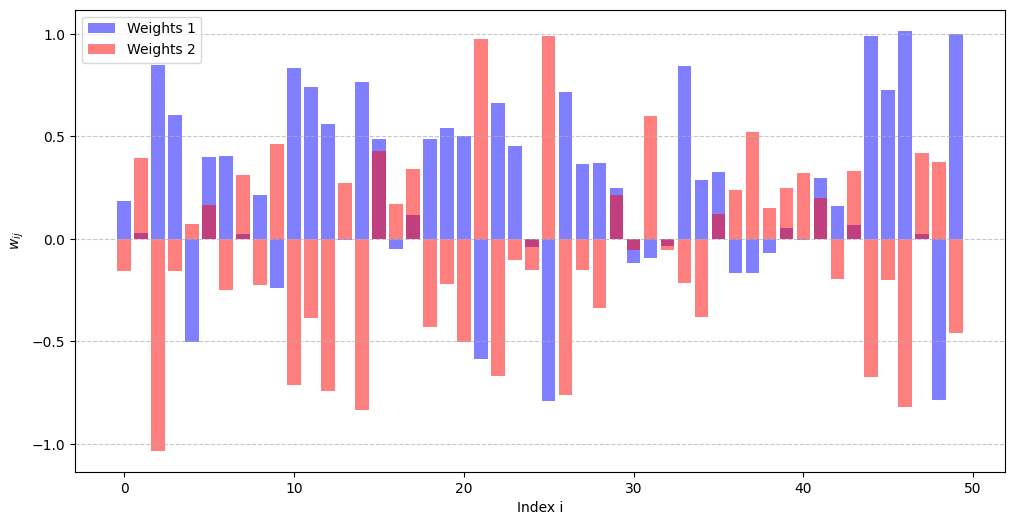

In [19]:
indices = np.arange(50)

plt.figure(figsize=(12, 6))

plt.bar(indices, W_final[:, 0], color='blue', alpha=0.5, label='Weights 1')
plt.bar(indices, W_final[:, 1], color='red', alpha=0.5, label='Weights 2')

plt.xlabel('Index i')
plt.ylabel(r'$w_{ij}$')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

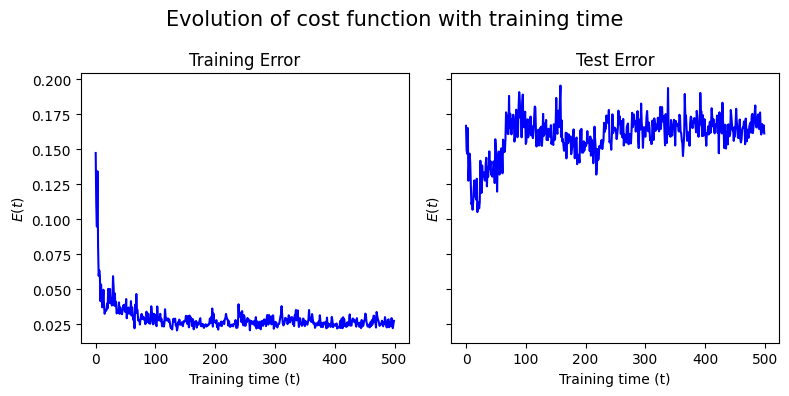

In [20]:
# Plot the output
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4), sharey = "all")

plt.suptitle("Evolution of cost function with training time", fontsize=15)
ax[0].set_title("Training Error")
ax[1].set_title("Test Error")

ax[0].plot(np.arange(t_max), E_train, label=f"$P={P}$", color="blue")
ax[1].plot(np.arange(t_max), E_test, label= f"$P={P}$", color="blue")

ax[0].set_xlabel('Training time (t)')
ax[1].set_xlabel('Training time (t)')
ax[0].set_ylabel(r'$E(t)$')
ax[1].set_ylabel(r'$E(t)$')

plt.tight_layout()
handles, labels = ax[0].get_legend_handles_labels()
#fig.legend(handles, labels,loc = 'center', bbox_to_anchor=(1.1, 0.5))
plt.show()

**Many repeats**

---

Repeat the procedure above for $R = 10$

- repeats of SGD
- randomized splits of the data set

Overall, check the robustness of the curve shape against these randomizations

In [22]:
# Select the train and test data
xi_train, xi_test = xi_data[:, :P], xi_data[:, P:(P+Q)]
tau_train, tau_test = tau_data[:P], tau_data[P:(P+Q)]

# Initialize relevant output

E_train_array = np.empty((R, t_max))
E_test_array = np.empty((R, t_max))

# Train the network many times
for i in range(R):
  _, E_train_array[i, :], E_test_array[i, :] = learn_NN(xi_train, tau_train, xi_test, tau_test, t_max = t_max)

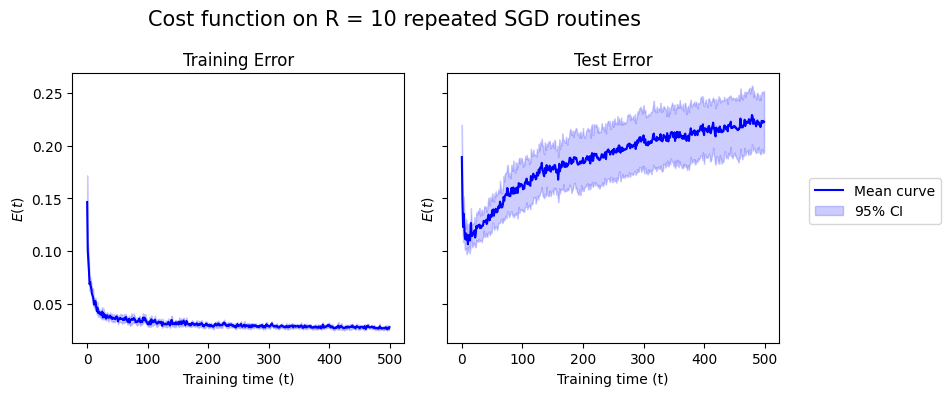

In [23]:
# The mean curve and its (time dependent) std
E_train_avg = np.mean(E_train_array, axis = 0)
E_train_std = np.std(E_train_array, axis = 0)

E_test_avg = np.mean(E_test_array, axis = 0)
E_test_std = np.std(E_test_array, axis = 0)

factor = 1.96 / np.sqrt(R)  # For 95% CI

# Actual plot

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4), sharey = "all")

plt.suptitle(f"Cost function on R = {R} repeated SGD routines", fontsize=15)
ax[0].set_title("Training Error")
ax[1].set_title("Test Error")

ax[0].plot(np.arange(t_max), E_train_avg, label=f"Mean curve", color = "blue")
ax[1].plot(np.arange(t_max), E_test_avg, label= f"Mean curve", color = "blue")

ax[0].fill_between(np.arange(t_max), E_train_avg - factor * E_train_std, E_train_avg + factor * E_train_std,
                   color = "blue", alpha = 0.2, label = r"$95 \%$ CI")
ax[1].fill_between(np.arange(t_max), E_test_avg - factor * E_test_std, E_test_avg + factor * E_test_std,
                   color = "blue", alpha = 0.2, label = r"$95 \%$ CI")

ax[0].set_xlabel('Training time (t)')
ax[1].set_xlabel('Training time (t)')
ax[0].set_ylabel(r'$E(t)$')
ax[1].set_ylabel(r'$E(t)$')

plt.tight_layout()

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels,loc = 'center', bbox_to_anchor=(1.1, 0.5))

plt.show()

In [25]:
# Initialize relevant output

E_train_array = np.empty((R, t_max))
E_test_array = np.empty((R, t_max))

# Train many data sets ONCE
for i in range(R):
  # Select the train and test data randomized
  idx_list = rng.choice(xi_data.shape[1], size = P+Q, replace = False)

  xi_train, xi_test = xi_data[:, idx_list[:P]], xi_data[:, idx_list[P:]]
  tau_train, tau_test = tau_data[idx_list[:P]], tau_data[idx_list[P:]]

  # Train
  _, E_train_array[i, :], E_test_array[i, :] = learn_NN(xi_train, tau_train, xi_test, tau_test, t_max = t_max)

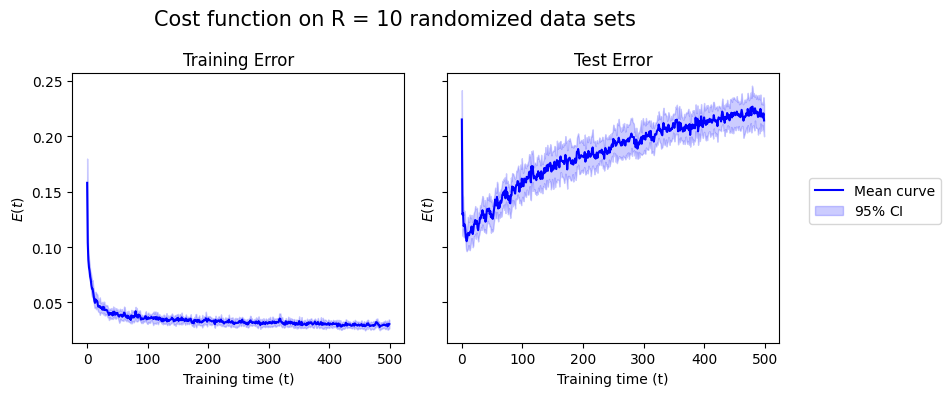

In [26]:
# The mean curve and its (time dependent) std
E_train_avg = np.mean(E_train_array, axis = 0)
E_train_std = np.std(E_train_array, axis = 0)

E_test_avg = np.mean(E_test_array, axis = 0)
E_test_std = np.std(E_test_array, axis = 0)

factor = 1.96 / np.sqrt(R)  # For 95% CI

# Actual plot

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4), sharey = "all")

plt.suptitle(f"Cost function on R = {R} randomized data sets", fontsize=15)
ax[0].set_title("Training Error")
ax[1].set_title("Test Error")

ax[0].plot(np.arange(t_max), E_train_avg, label=f"Mean curve", color = "blue")
ax[1].plot(np.arange(t_max), E_test_avg, label= f"Mean curve", color = "blue")

ax[0].fill_between(np.arange(t_max), E_train_avg - factor * E_train_std, E_train_avg + factor * E_train_std,
                   color = "blue", alpha = 0.2, label = r"$95 \%$ CI")
ax[1].fill_between(np.arange(t_max), E_test_avg - factor * E_test_std, E_test_avg + factor * E_test_std,
                   color = "blue", alpha = 0.2, label = r"$95 \%$ CI")

ax[0].set_xlabel('Training time (t)')
ax[1].set_xlabel('Training time (t)')
ax[0].set_ylabel(r'$E(t)$')
ax[1].set_ylabel(r'$E(t)$')

plt.tight_layout()

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels,loc = 'center', bbox_to_anchor=(1.1, 0.5))

plt.show()

# Bonus

**Impact of training data**

How do these curves change when we have a different amount of training data? Display the robustness over SGD training randomness

In [27]:
P_list = [20, 100, 500, 2500]
Q = 100
t_max = 500
R = 10

rng = np.random.default_rng(42)

In [28]:
# Initialize relevant output
# Runtime: 13 min

E_train_array = np.empty((R, t_max, len(P_list)))
E_test_array = np.empty((R, t_max, len(P_list)))

for idx_P in range(len(P_list)):
  P = P_list[idx_P]

  # Select the train and test data ONCE
  xi_train, xi_test = xi_data[:, :P], xi_data[:, P:(P+Q)]
  tau_train, tau_test = tau_data[:P], tau_data[P:(P+Q)]

  # Train the network R times
  for i in range(R):
    _, E_train_array[i, :, idx_P], E_test_array[i, :, idx_P] = learn_NN(xi_train, tau_train, xi_test, tau_test, t_max = t_max)

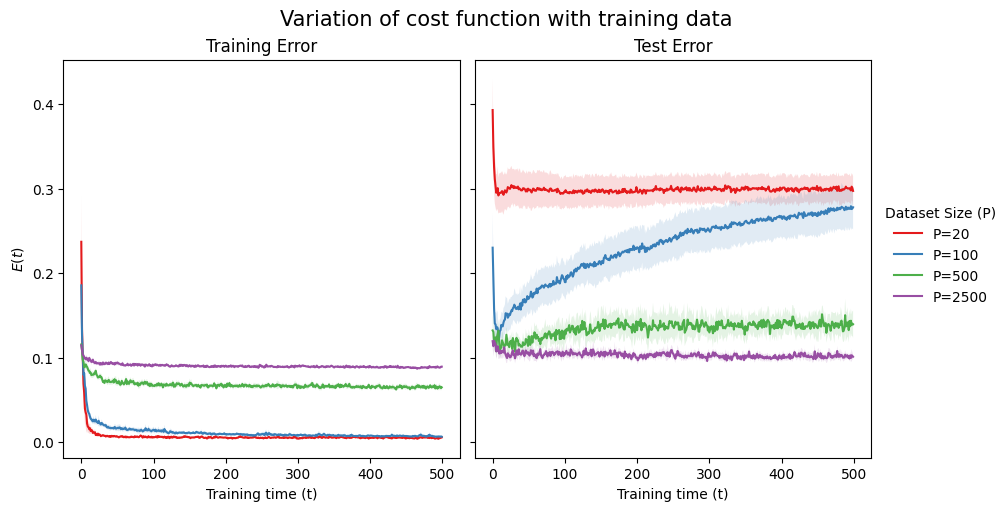

In [29]:
colors_list = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

factor = 1.96 / np.sqrt(R)
t_axis = np.arange(t_max)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, layout='constrained')
plt.suptitle("Variation of cost function with training data", fontsize=15)

for idx_P in range(len(P_list)):
    P = P_list[idx_P]
    color = colors_list[idx_P]

    train_mean = np.mean(E_train_array[:, :, idx_P], axis=0)
    train_std = np.std(E_train_array[:, :, idx_P], axis=0)

    test_mean = np.mean(E_test_array[:, :, idx_P], axis=0)
    test_std = np.std(E_test_array[:, :, idx_P], axis=0)

    ax[0].plot(t_axis, train_mean, color=color, label=f"P={P}")
    ax[0].fill_between(t_axis,
                        train_mean - factor * train_std,
                        train_mean + factor * train_std,
                        color=color, alpha=0.15, edgecolor=None)

    ax[1].plot(t_axis, test_mean, color=color, label=f"P={P}")
    ax[1].fill_between(t_axis,
                        test_mean - factor * test_std,
                        test_mean + factor * test_std,
                        color=color, alpha=0.15, edgecolor=None)

ax[0].set_title("Training Error")
ax[1].set_title("Test Error")

ax[0].set_ylabel(r"$E(t)$")
ax[0].set_xlabel("Training time (t)")
ax[1].set_xlabel("Training time (t)")

#ax[0].set_yscale('log')
#ax[1].set_yscale('log')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='outside center right', title="Dataset Size (P)", frameon=False)

plt.show()